1.80701601965


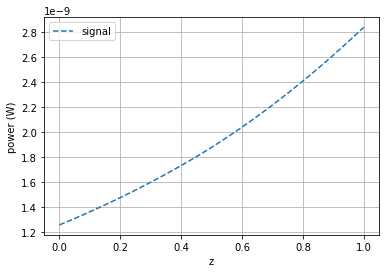

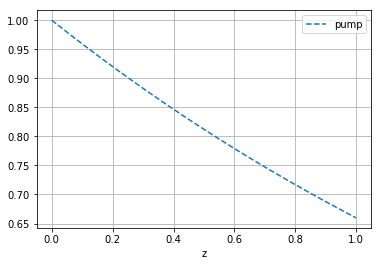

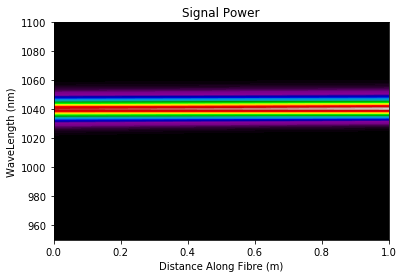

In [1]:
from __future__ import division
import scipy as sp
import numpy as np
import pylab as plt
import time, sys
import warnings
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.misc import factorial
from numpy.random import normal
from scipy.integrate import complex_ode
from scipy.constants import c, h, hbar, k
from scipy.integrate import odeint
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# -----------------------------------------------------
# Define correctly shifted & scaled FFT/IFFT functions

# NOTE: the ifft scales correctly, fft needs to be
#       multiplied by 1/N, where N is number of points
# -----------------------------------------------------
def fft_f(x):
    return fftshift(ifft(fftshift(x)))  # use ifft to go from tms -> oms (or freqs), here we call this the forward FFT


def fft_b(x):
    return fftshift(fft(fftshift(x)))  # use fft to go from oms (or freqs) -> tms, here we call this the backward FFT

#constant
c_cm_ps = c * 1e2 / 1e12
c = 3e8 #m/s
pump_wl = 976e-9 #m
signal_wl = 1040e-9 #m
v_pump = c/pump_wl
v_signal = c/signal_wl
a_core = 5e-6 #m
a_clad = 130e-6 #m
area_core = sp.pi*(a_core**2)
area_innerclad = sp.pi*(a_clad**2)
Gamma_signal = 0.6804 #modal overlap - see modal.overlap.m
Gamma_pump = area_core/area_innerclad #modal overlap - see S. Mohammadian et al. / Optical Fiber Technology 19 eqn 16
sigma_a_1040 = 0.0345e-24 #m^2
sigma_e_1040 = 0.512e-24 #m^2
sigma_a_976 = 2.48e-24 #m^2
sigma_e_976 = 2.48e-24 #m^2
tau_21 = 1.4e-3 #ms, Fluorescence lifetime - spontaneous decay rate from level 2 to level 1
rho = 1.3*10e25 #m^2
z = np.linspace(0,1,1001)
delta_z = 1 / 1000


# Absorption spectrum
def abs_spec(wls):
    A_j_m = 10 ** -27 * np.array([180, 360, 510, 160, 2325])  # [m^2]
    lambda_j_m = np.array([950, 895, 918, 971, 975, 978, 1025, 1050, 1030])  # [nm]
    w_j_m = np.array([70, 24, 22, 12, 4, 12, 20, 60, 90])  # [nm]

    summation = 0
    for i in range(len(A_j_m)):
        summation += A_j_m[i] * sp.exp(-1 * ((wls - lambda_j_m[i]) / w_j_m[i]) ** 2)

    return summation

# Emission spectrum
def emi_spec(wls):
    A_j_m = 10 ** -27 * np.array([2325, 160, 340, 175, 150])  # [m^2]
    lambda_j_m = np.array([975, 978, 1025, 1050, 1030])  # [nm]
    w_j_m = np.array([4, 12, 20, 60, 90])  # [nm]

    summation = 0
    for i in range(len(A_j_m)):
        summation += A_j_m[i] * sp.exp(-1 * ((wls - lambda_j_m[i]) / w_j_m[i]) ** 2)

    return summation

def power_signal(p, z, N1, N2, k):

    #pump, signal = p

    signal = p

    dpdt = Gamma_signal * (e_spec_calculated[k] * N2 - a_spec_calculated[k] * N1) * rho * signal

    return dpdt

def power_pump(p, z, N1, N2):

    pump = p
    dp_pumpdt = Gamma_pump * (sigma_e_976 * N2 - sigma_a_976 * N1) * rho * pump

    return dp_pumpdt

def inversion(signal, pump):

    # treat the pump as a delta function in the Frequency Domain, at 976 nm
    R12 = Gamma_pump * sigma_a_976 * pump / (h * v_pump * area_core)
    R21 = Gamma_pump * sigma_e_976 * pump / (h * v_pump * area_core)

    W21_sum = 0
    W12_sum = 0

    # loops through all the wavelengths to calculate total W12, W21
    for k in range(0, len(wl_grid)):
        wavelength = wl_grid[k]
        W12 = Gamma_signal * a_spec_calculated[k] * signal[k] / (h * c / (wavelength * (10 ** -9)) * area_core)
        W21 = Gamma_signal * e_spec_calculated[k] * signal[k]/ (h * c / (wavelength * (10 ** -9)) * area_core)

        W12_sum = W12_sum + W12
        W21_sum = W21_sum + W21

    N2 = (R12 + W12_sum) / (R12 + R21 + W12_sum + W21_sum + 1 / tau_21)
    #N1 = 1 - (R12 + W12_sum) / (R12 + R21 + W12_sum + W21_sum + 1 / tau_21)

    return N2


if __name__ == "__main__":

    #   ---------------
    #   Grid properties
    #   ---------------
    c_cm_ps = c * 1e2 / 1e12
    c_nm_ps = c * 1e9 / 1e12
    num_bits = 12
    num_grid_points = 2 ** num_bits  # use powers of 2 for efficient FFT's
    time_window_width = 50  # [ps]
    tms = sp.linspace(-time_window_width / 2, time_window_width / 2, num_grid_points)

    wavelength_signal = 1040.0  # [nm]
    wavelength_pump = 976.0  # [nm]
    num_points = len(tms)  # number of grid points
    dt = tms[1] - tms[0]  # time spacing [ps]
    freqs = fftshift(fftfreq(num_points, dt))  # [THz]
    omegas_centered_on_zero = (2 * sp.pi) * freqs  # angular frequency about zero
    omega_centre_signal = (2 * sp.pi * c_nm_ps) / wavelength_signal  # angular reference frequency [TCycles]
    omega_centre_pump = (2 * sp.pi * c_nm_ps) / wavelength_pump  # angular reference frequency [TCycles]

    omegas = omegas_centered_on_zero + omega_centre_signal
    omegas_pump = omegas_centered_on_zero + omega_centre_pump
    wls = 2 * sp.pi * c_nm_ps / omegas  # wavelength grid [nm] - need a wls grid for the signal centered at 1040 nm
    wls_pump = 2 * sp.pi * c_nm_ps / omegas_pump  # wavelength grid [nm]- need a wls grid for the pump centered at 976 nm

    #   -----------
    #   Input Signal
    #   -----------
    pulse_duration_fwhm = 0.120  # Transform limited FWHM [ps]
    signal_power = 26095.5  ## [W] peak power ASSUME coupling eff of 70% #avg_power*period_osc/(pulse_duration_fwhm*(10**-12)) Using online calculator
    pulse_duration = pulse_duration_fwhm / (2 * np.log(1 + np.sqrt(2)))  # tranform limited
    input_efield_tms = ((sp.sqrt(signal_power) / sp.cosh(tms / pulse_duration)) + 0j)  # transform input pulse
    input_efield_omegas = fft_f(input_efield_tms)
    signal_inten_omegas = abs((input_efield_omegas)) ** 2

    signal_interpolation = sp.interpolate.interp1d(wls, signal_inten_omegas, bounds_error=False, fill_value=0)

    wl_grid = sp.linspace(950, 1100, len(wls))  # linear grid of wls for one-to-one correspondance

    input_inten_wls = signal_interpolation(wl_grid)

    a_spec = abs_spec(wl_grid)
    e_spec = emi_spec(wl_grid)

    a_spec_calculated = []
    e_spec_calculated = []

    # calculate the absorption and emission spectra once and save the results to an array to cut down on calculations
    for wl in wl_grid:
        a_spec_calculated.append(abs_spec(wl))
        e_spec_calculated.append(emi_spec(wl))

    pump = 1
    N2 = inversion(input_inten_wls, pump)
    N1 = 1-N2

    # P_p and P_s

    totalSignal = []

    # For example and illustration, solve power equations for 1 m
    for k in range(0, len(wl_grid)):
        p_init = input_inten_wls[k]
        solution = odeint(power_signal, p_init, z, args=(N1, N2, k))
        totalSignal.append(solution[:,0])

    pump_solution = odeint(power_pump, pump, z, args=(N1, N2))
    pump_absorption = -10*sp.log10(max(pump_solution[1000])/max(pump_solution[0])) #check to see if pump absorption matches Data Sheet

    print(pump_absorption)

    signalPlotting = sp.asarray(totalSignal)


    plt.figure()
    plt.plot(z, solution[:,0], '--', label='signal')
    plt.legend(loc='best')
    plt.xlabel('z')
    plt.ylabel('power (W)')
    plt.grid()

    plt.figure()
    plt.plot(z, pump_solution[:, 0], '--', label='pump')
    plt.legend(loc='best')
    plt.xlabel('z')
    plt.grid()

    plt.figure()
    plt.imshow(signalPlotting, origin='lower',
               extent=(0, max(z), min(wl_grid), max(wl_grid)), aspect='auto',
               cmap='nipy_spectral', interpolation='bilinear')
    plt.ylabel('WaveLength (nm)')
    plt.xlabel('Distance Along Fibre (m)')
    plt.title('Signal Power')


    plt.show()